## Using RNN for feature extraction from audio input

The internet suggest we should use RNN on spectogram (as omer did with cnn) by considering each column of the spectogram as the current input (in the time dimension) and then using the recurrent network.

Working with the raw audio is not so simple as I originally thought because even if I would use LSTM (which can handle longer sequences than simple RNN), we are talking about sequences of length of ~1e-6 and I think we won't be able to train this well naively. It is possible to do Truncated backpropagation through time (TBPTT) and if time would allow us, we will try that as well but because using spectogram was suggested by the internet, we will go with it.

In [7]:
import sys; sys.path.append('..')
import torch
from torch.utils.data import random_split
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

AUDIO_PATH = '../data/audio'

TENSOR_PATH = '../data/specs'

METADATA_PATH = '../data/metadata.csv'

SEED = 42

torch.manual_seed(SEED)

### Data processing:

#### Playing with the data:

In [8]:
from pychorus.helpers import find_and_output_chorus
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
import librosa

For each song, we will focus only on the chorus. The idea behind this is both in term of performance and in term of computations. In terms of performance, the chorus contains the whole message of the song in just a few lines and also it will be the most powerful, highest energy, loudest, catchiest, and most memorable part of any song. Thus, it make sense that most tiktokers will choose this part for their video. In addition, in term of computation, working on shorter audio file (only the chorus compared to the whole song) / smaller spectogram will require less computations.

In order to do so, we will use pychorus library.

In [ ]:
x, sr = librosa.load('../data/audio/0e3CM2Fm4cpDtxjzYkdLAr.mp3')
start = int(find_and_output_chorus(input_file='../data/audio/0e3CM2Fm4cpDtxjzYkdLAr.mp3', output_file=None, clip_length=20))

And now let's plot the predicted chorus and hear it:

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x[start*sr:(start+30)*sr], sr=sr)

In [ ]:
chorus = x[start*sr:(start+20)*sr]
Audio(data = chorus, rate=sr)

and it really sounds like the real chorus (cut in the middle because I limit the duration to be 30 seconds).

Let's try to plot the spectogram of the chorus. 

In [ ]:
S = librosa.feature.melspectrogram(y=chorus, sr=sr) #n_fft=2048, hop_length=512 by default
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max(S))
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

It seems that the high frequencies as high dB, which might indicate more rhythmic song (in addition to the previous plot where we can see rapid changes in the signal). This in turn can indicate the virality of the song but we will let the model decide it.

Let's create the pipeline of the preprocessing.

#### Preprocessing pipeline:

The following is the basic pipeline:

                Raw audio -> calculate mean of channels -> extract chorus from audio -> create spectorgram from audio -> convert spectogram from amplitude to dB

In order to avoid redundant calculations and speed-up the training time, I will create all spectogram before the training and save them as files and only load them each epoch.

In [9]:
from torch.utils.data import random_split
from src.RNN_utils.audio_utils import rechannel, get_chorus, createSpect
import pandas as pd
import torch
from tqdm import tqdm
import torchaudio

AUDIO_PATH = '../data/audio'

TENSOR_PATH = '../data/specs'

METADATA_PATH = '../data/metadata.csv'

In [ ]:
import os

os.mkdir(TENSOR_PATH)

In [3]:
df = pd.read_csv(METADATA_PATH)

Let's start by applying the pipeline on the training set and save the new tensors as files:

In [ ]:
#for idx in tqdm(df.index):
for idx in tqdm(df.index):
    song_path = AUDIO_PATH + '/' + df.loc[idx,'id'] + '.mp3'
    #load the audio file
    aud = torchaudio.load(song_path)
    #convert the audio to mono audio
    aud = rechannel(aud,new_channel=1)
    #take only the part of the chorus from the signal
    aud = get_chorus(song_path, 20, aud)
    #create the mel-spectogram
    sgram = createSpect(aud, n_mels=64)
    torch.save(sgram,TENSOR_PATH + '/' + df.loc[idx,'id'] + '.pt')

Now, let's use the SoundDS class in order to create dataset from those tensors and then create dataloader for both the training and validation (test) sets:

In [4]:
from src.RNN_utils.dataset import SoundDS
myds = SoundDS(pd.read_csv('../data/metadata.csv'), '../data/specs/')

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

Next we will check that everything is working properly:

In [5]:
inputs, labels = next(iter(train_dl))

In [6]:
print(f'Batch input shape: {inputs.shape}')
print(f'Batch label shape: {labels.shape}')

Batch input shape: torch.Size([16, 2206, 64])
Batch label shape: torch.Size([16])


As we can see, each batch as 16 samples of shape (2206,64) - 2206 windows of time and 64 mel bins of frequencies. The number of channels is only one. Having the data loader, we can now move to the model part!

### The Model:

We will use RNN based model in this notebook.

Because our input is of length 2206 which is pretty long, we won't use the basic RNN unit but the LSTM (Long Short Term Memory). The advantage of LSTM on the basic RNN is the ability to "remember" information from far earlier inputs. In addition,it also handle the vanishing gradient problem which we might suffer from with the basic RNN because we have long sequence inputs.

In [10]:
import torch.nn as nn

In [11]:
class viralCls(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0, num_classes=2):
        super().__init__()
        self.feature_extractor = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout= dropout if num_layers > 1 else 0.0)
        self.clf = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.LeakyReLU(),
            nn.Dropout1d(p=dropout),
            nn.Linear(512, 512),
            nn.Dropout1d(p=dropout),
            nn.LeakyReLU(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

    def forward(self,X,h0=None,c0=None):
        batch_size = X.shape[0]
        if h0 is None or c0 is None:
            h0 = torch.normal(mean=0.0,std=1.0,size=(self.num_layers,batch_size,self.hidden_size))
            c0 = torch.normal(mean=0.0,std=1.0,size=(self.num_layers,batch_size,self.hidden_size))
        
        #extracting the features from the spectogram.
        out, _ = self.feature_extractor(X, (h0, c0))

        #classifing according to the extracted features.
        prob = self.clf(out[:,-1,:])
        return prob

Let's see if the new classifier is working on random input:

In [12]:
model = viralCls(5,10)
X = torch.rand(10,20,5)
model(X).shape

torch.Size([10, 2])

The input is 10 samples, each is with length of 20 and 5 features for each time. The output is probability distribution over 2 classes for all 10 samples. Success!

### The training loop:

As before, I will first create the loaders of the data:

In [13]:
from src.RNN_utils.dataset import SoundDS
df = pd.read_csv('../data/metadata.csv')
myds = SoundDS(df, '../data/specs/')

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

In [14]:
b_size, seq_len, input_size = next(iter(train_dl))[0].shape
num_batches = len(train_dl)
hidden_size = 64

let's visualize on sample from the dataset

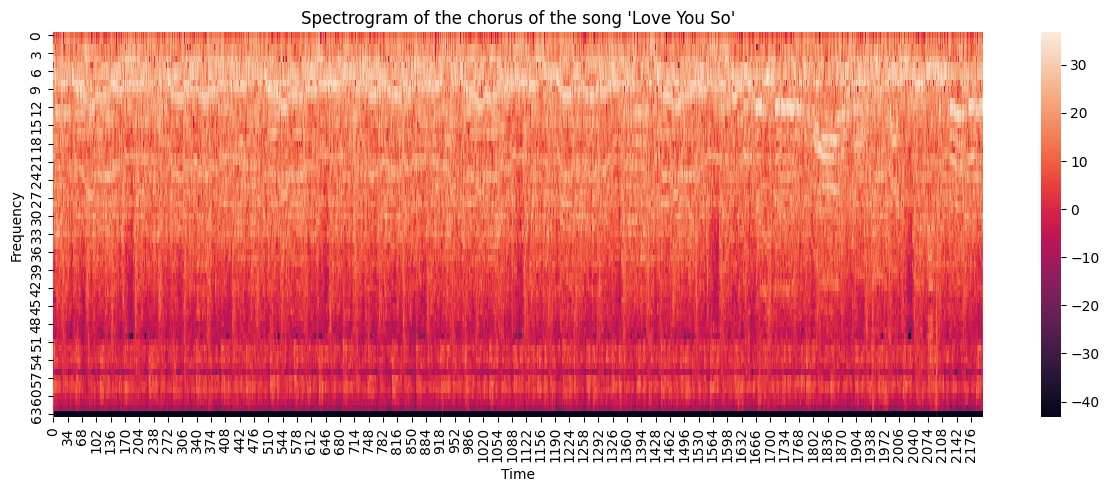

In [29]:
import seaborn as sns

plt.figure(figsize = (15,5))
plt.title("Spectrogram of the chorus of the song 'Love You So'")
ax = sns.heatmap(myds[0][0].t())
ax.set(xlabel='Time', ylabel='Frequency')
plt.show()

#### Overfitting the model:

Let's create the classification model:

In [22]:
model = viralCls(input_size, hidden_size)

We will use cross entropy loss and Adam optimizer:

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=5e-3)

epochs = 10

Let's start by train the model to overfitted to the first batch: 

In [24]:
(X,y) = next(iter(train_dl))
for epoch in range(epochs):
    optimizer.zero_grad()
    y_prob = model(X)
    loss = criterion(y_prob,y)
    loss.backward()
    optimizer.step()
    loss = loss.item()
    acc = torch.sum(torch.argmax(y_prob,dim=1)==y).item()/32
    #scheduler.step()
    print(f'Epoch #{epoch}: Loss - {loss}, Accuracy - {acc}')

Epoch #0: Loss - 0.6800753474235535, Accuracy - 0.75
Epoch #1: Loss - 0.5603136420249939, Accuracy - 0.75
Epoch #2: Loss - 0.5532577633857727, Accuracy - 0.75
Epoch #3: Loss - 0.5443695187568665, Accuracy - 0.75
Epoch #4: Loss - 0.5148026347160339, Accuracy - 0.78125
Epoch #5: Loss - 0.47771549224853516, Accuracy - 0.84375
Epoch #6: Loss - 0.41493549942970276, Accuracy - 0.90625
Epoch #7: Loss - 0.360433429479599, Accuracy - 1.0
Epoch #8: Loss - 0.3279872536659241, Accuracy - 1.0
Epoch #9: Loss - 0.3159254491329193, Accuracy - 1.0


#### Test:

In [32]:
from src.RNN_utils.trainer import trainer
from src.RNN_utils.cross_val import crossValidate

config = {'lr':1e-4, 'weight_decay':1e-5, 'step_size': 5, 'gamma': 0.5}
model = viralCls(input_size, hidden_size, num_layers=2, dropout=0.0)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])

train_model = trainer(model,criterion,optimizer,scheduler)

In [33]:
results = train_model.train(train_dl,40,True)

Train Batch: 100%|██████████| 92/92 [01:54<00:00,  1.25s/it]


Epoch #0: Loss - 61.26775115728378, Accuracy - 0.6317776252573781


Train Batch: 100%|██████████| 92/92 [02:01<00:00,  1.32s/it]


Epoch #1: Loss - 60.47148710489273, Accuracy - 0.6317776252573781


Train Batch: 100%|██████████| 92/92 [02:02<00:00,  1.34s/it]


Epoch #2: Loss - 59.90353399515152, Accuracy - 0.6317776252573781


Train Batch: 100%|██████████| 92/92 [02:15<00:00,  1.48s/it]


Epoch #3: Loss - 59.53269562125206, Accuracy - 0.6317776252573781


Train Batch: 100%|██████████| 92/92 [02:21<00:00,  1.53s/it]


Epoch #4: Loss - 58.77843600511551, Accuracy - 0.6341798215511325


Train Batch: 100%|██████████| 92/92 [02:24<00:00,  1.57s/it]


Epoch #5: Loss - 57.751402735710144, Accuracy - 0.6640356897735072


Train Batch: 100%|██████████| 92/92 [02:24<00:00,  1.57s/it]


Epoch #6: Loss - 57.02684533596039, Accuracy - 0.6753603294440631


Train Batch: 100%|██████████| 92/92 [02:26<00:00,  1.59s/it]


Epoch #7: Loss - 56.02047115564346, Accuracy - 0.6863417982155113


Train Batch: 100%|██████████| 92/92 [02:26<00:00,  1.59s/it]


Epoch #8: Loss - 55.368976682424545, Accuracy - 0.7021276595744681


Train Batch: 100%|██████████| 92/92 [02:31<00:00,  1.64s/it]


Epoch #9: Loss - 54.40495112538338, Accuracy - 0.7065888812628689


Train Batch: 100%|██████████| 92/92 [02:31<00:00,  1.65s/it]


Epoch #10: Loss - 54.06531971693039, Accuracy - 0.7282086479066575


Train Batch: 100%|██████████| 92/92 [02:28<00:00,  1.61s/it]


Epoch #11: Loss - 53.41788813471794, Accuracy - 0.7333562113932739


Train Batch: 100%|██████████| 92/92 [02:27<00:00,  1.60s/it]


Epoch #12: Loss - 52.387282609939575, Accuracy - 0.7371310912834592


Train Batch: 100%|██████████| 92/92 [02:27<00:00,  1.60s/it]


Epoch #13: Loss - 52.487262189388275, Accuracy - 0.7470830473575841


Train Batch: 100%|██████████| 92/92 [02:30<00:00,  1.63s/it]


Epoch #14: Loss - 51.56839817762375, Accuracy - 0.7501715854495539


Train Batch: 100%|██████████| 92/92 [02:29<00:00,  1.62s/it]


Epoch #15: Loss - 51.78465986251831, Accuracy - 0.7632120796156486


Train Batch: 100%|██████████| 92/92 [02:30<00:00,  1.64s/it]


Epoch #16: Loss - 50.90328598022461, Accuracy - 0.7645847632120796


Train Batch: 100%|██████████| 92/92 [02:29<00:00,  1.62s/it]


Epoch #17: Loss - 50.456063747406006, Accuracy - 0.7656142759094029


Train Batch: 100%|██████████| 92/92 [02:28<00:00,  1.61s/it]


Epoch #18: Loss - 50.15788748860359, Accuracy - 0.7704186684969114


Train Batch: 100%|██████████| 92/92 [02:28<00:00,  1.61s/it]


Epoch #19: Loss - 50.369179874658585, Accuracy - 0.7755662319835278


Train Batch: 100%|██████████| 92/92 [02:29<00:00,  1.62s/it]


Epoch #20: Loss - 49.63333573937416, Accuracy - 0.7752230610844201


Train Batch: 100%|██████████| 92/92 [02:30<00:00,  1.64s/it]


Epoch #21: Loss - 49.7738399207592, Accuracy - 0.7779684282772821


Train Batch: 100%|██████████| 92/92 [02:28<00:00,  1.62s/it]


Epoch #22: Loss - 49.48019635677338, Accuracy - 0.7783115991763898


Train Batch: 100%|██████████| 92/92 [02:29<00:00,  1.62s/it]


Epoch #23: Loss - 49.32556515932083, Accuracy - 0.7810569663692519


Train Batch: 100%|██████████| 92/92 [02:28<00:00,  1.61s/it]


Epoch #24: Loss - 49.2114691734314, Accuracy - 0.7827728208647907


Train Batch: 100%|██████████| 92/92 [02:31<00:00,  1.65s/it]


Epoch #25: Loss - 49.07833382487297, Accuracy - 0.7827728208647907


Train Batch: 100%|██████████| 92/92 [03:44<00:00,  2.44s/it]


Epoch #26: Loss - 49.378567188978195, Accuracy - 0.785175017158545


Train Batch: 100%|██████████| 92/92 [03:44<00:00,  2.44s/it]


Epoch #27: Loss - 49.16073563694954, Accuracy - 0.7844886753603294


Train Batch: 100%|██████████| 92/92 [03:18<00:00,  2.16s/it]


Epoch #28: Loss - 48.91147589683533, Accuracy - 0.7844886753603294


Train Batch: 100%|██████████| 92/92 [03:16<00:00,  2.14s/it]


Epoch #29: Loss - 48.940154790878296, Accuracy - 0.7855181880576527


Train Batch: 100%|██████████| 92/92 [02:55<00:00,  1.91s/it]


Epoch #30: Loss - 49.66405490040779, Accuracy - 0.7872340425531915


Train Batch: 100%|██████████| 92/92 [03:35<00:00,  2.35s/it]


Epoch #31: Loss - 48.78853151202202, Accuracy - 0.7875772134522993


Train Batch: 100%|██████████| 92/92 [03:27<00:00,  2.25s/it]


Epoch #32: Loss - 48.746901988983154, Accuracy - 0.7865477007549759


Train Batch: 100%|██████████| 92/92 [03:11<00:00,  2.08s/it]


Epoch #33: Loss - 48.95296627283096, Accuracy - 0.7875772134522993


Train Batch: 100%|██████████| 92/92 [02:55<00:00,  1.91s/it]


Epoch #34: Loss - 48.68217620253563, Accuracy - 0.7875772134522993


Train Batch: 100%|██████████| 92/92 [03:28<00:00,  2.26s/it]


Epoch #35: Loss - 48.605223566293716, Accuracy - 0.7889498970487303


Train Batch: 100%|██████████| 92/92 [03:13<00:00,  2.10s/it]


Epoch #36: Loss - 48.65191653370857, Accuracy - 0.7875772134522993


Train Batch: 100%|██████████| 92/92 [03:11<00:00,  2.08s/it]


Epoch #37: Loss - 48.70128971338272, Accuracy - 0.7889498970487303


Train Batch: 100%|██████████| 92/92 [03:07<00:00,  2.04s/it]


Epoch #38: Loss - 48.578828394412994, Accuracy - 0.7886067261496225


Train Batch: 100%|██████████| 92/92 [03:19<00:00,  2.17s/it]

Epoch #39: Loss - 48.60320141911507, Accuracy - 0.7896362388469458


Text(0, 0.5, 'accuracy')

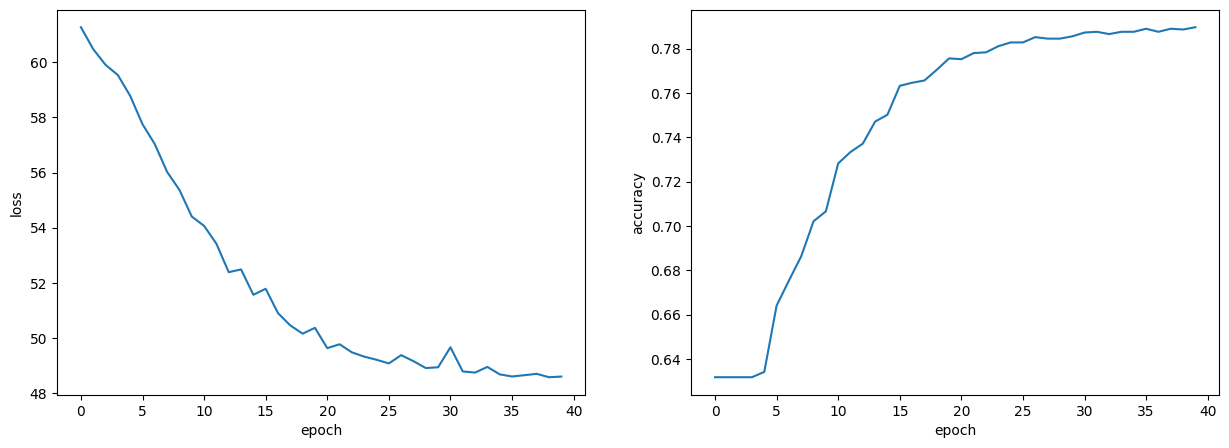

In [36]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(range(40), results['loss'])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

axs[1].plot(range(40), results['accuracy'])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')

#### Cross validation:

and now for the real training:

In [25]:
configs = []
results = []

In [26]:
from src.RNN_utils.trainer import trainer
from src.RNN_utils.cross_val import crossValidate

config = {'lr':1e-4, 'weight_decay':9e-3, 'step_size': 5, 'gamma': 0.5}
model = viralCls(input_size, hidden_size, num_layers=1, dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])

train_model = trainer(model,criterion,optimizer,scheduler)

In [27]:
cv_obj = crossValidate(train_ds=train_ds, folds=3)

In [28]:
results.append(cv_obj.runCV(train_model, epochs=40))
configs.append(config)

Fold #0:
Epoch 0/40:  {'loss_train': 41.14386332035065, 'accuracy_train': 0.6235839340885685, 'loss_test': 20.47032070159912, 'accuracy_test': 0.6430041152263375}
Epoch 1/40:  {'loss_train': 40.69587284326553, 'accuracy_train': 0.6261585993820803, 'loss_test': 20.404755890369415, 'accuracy_test': 0.6430041152263375}
Epoch 2/40:  {'loss_train': 40.6082838177681, 'accuracy_train': 0.6261585993820803, 'loss_test': 20.394651770591736, 'accuracy_test': 0.6430041152263375}
Epoch 3/40:  {'loss_train': 40.692900240421295, 'accuracy_train': 0.6261585993820803, 'loss_test': 20.473462283611298, 'accuracy_test': 0.6430041152263375}
Epoch 4/40:  {'loss_train': 40.763590812683105, 'accuracy_train': 0.6261585993820803, 'loss_test': 20.45987194776535, 'accuracy_test': 0.6430041152263375}
Epoch 5/40:  {'loss_train': 40.52208894491196, 'accuracy_train': 0.6261585993820803, 'loss_test': 20.53080004453659, 'accuracy_test': 0.6430041152263375}
Epoch 6/40:  {'loss_train': 40.50220489501953, 'accuracy_train'

KeyboardInterrupt: 

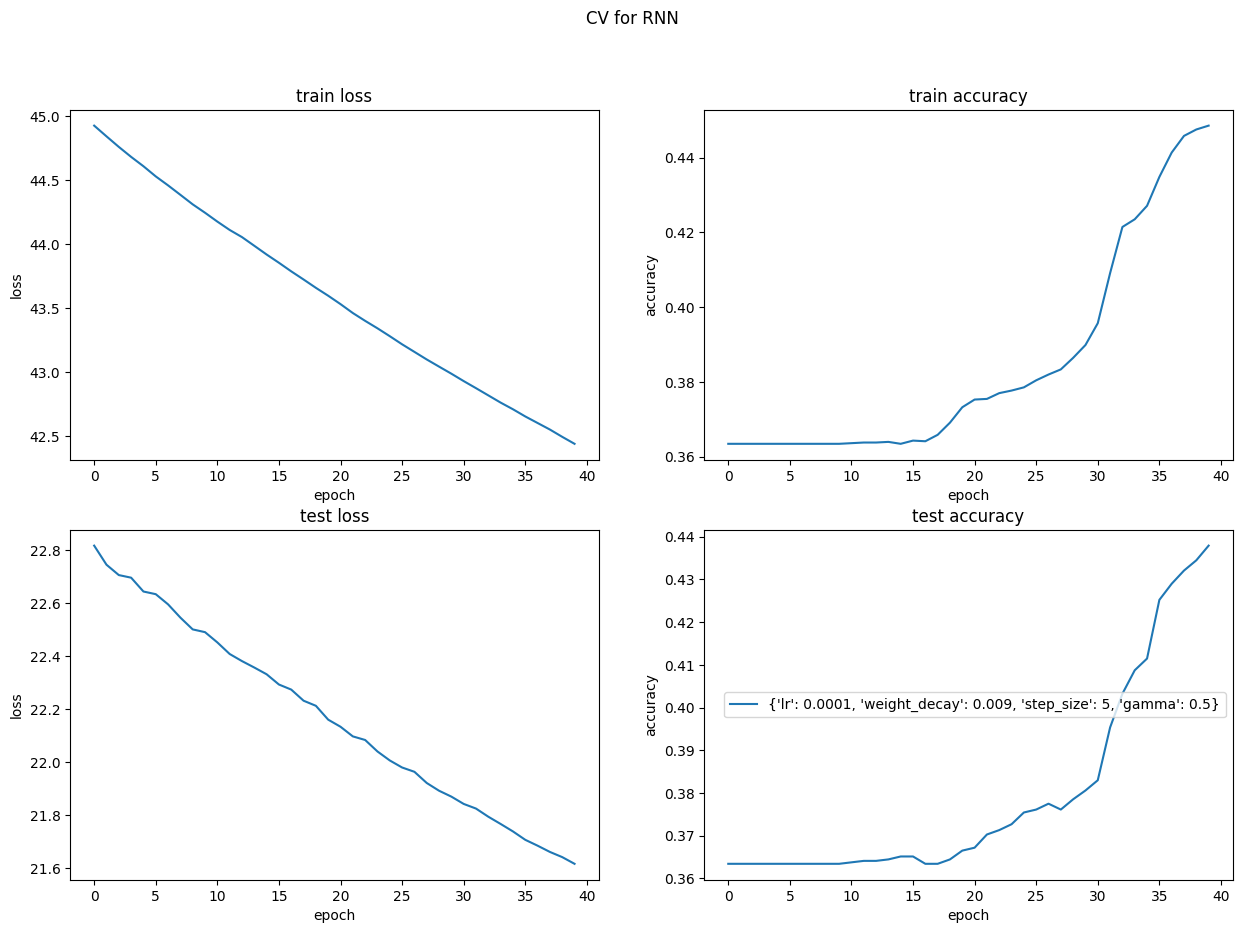

In [22]:
from src.RNN_utils.cross_val import plotCV

plotCV(results, configs,title='CV for RNN')

#### Training:

In [9]:
from src.RNN_utils.trainer import trainer

model = viralCls(input_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.5)

train_model = trainer(model,criterion,optimizer,scheduler)

In [10]:
results = train_model.train(train_dl, 50, True)

Train Batch: 100%|██████████| 92/92 [00:49<00:00,  1.87it/s]


Epoch #0: Loss - 60.964875876903534, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s]


Epoch #1: Loss - 60.423157036304474, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:50<00:00,  1.84it/s]


Epoch #2: Loss - 60.13418298959732, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:53<00:00,  1.72it/s]


Epoch #3: Loss - 60.00037455558777, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:52<00:00,  1.75it/s]


Epoch #4: Loss - 59.96689349412918, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:49<00:00,  1.84it/s]


Epoch #5: Loss - 59.251351058483124, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:52<00:00,  1.74it/s]


Epoch #6: Loss - 59.97588676214218, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:58<00:00,  1.58it/s]


Epoch #7: Loss - 59.71102350950241, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:56<00:00,  1.64it/s]


Epoch #8: Loss - 60.042579650878906, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:50<00:00,  1.83it/s]


Epoch #9: Loss - 58.92647331953049, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:52<00:00,  1.74it/s]


Epoch #10: Loss - 58.934528052806854, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:55<00:00,  1.66it/s]


Epoch #11: Loss - 58.69205057621002, Accuracy - 0.6365820178448868


Train Batch: 100%|██████████| 92/92 [01:01<00:00,  1.51it/s]


Epoch #12: Loss - 58.73748975992203, Accuracy - 0.651681537405628


Train Batch: 100%|██████████| 92/92 [01:01<00:00,  1.51it/s]


Epoch #13: Loss - 58.327474534511566, Accuracy - 0.6547700754975978


Train Batch: 100%|██████████| 92/92 [00:58<00:00,  1.58it/s]


Epoch #14: Loss - 58.0875568985939, Accuracy - 0.6564859299931366


Train Batch: 100%|██████████| 92/92 [01:06<00:00,  1.39it/s]


Epoch #15: Loss - 57.870153307914734, Accuracy - 0.6650652024708305


Train Batch: 100%|██████████| 92/92 [01:01<00:00,  1.51it/s]


Epoch #16: Loss - 56.92665520310402, Accuracy - 0.6750171585449554


Train Batch: 100%|██████████| 92/92 [01:04<00:00,  1.43it/s]


Epoch #17: Loss - 57.117179811000824, Accuracy - 0.6650652024708305


Train Batch: 100%|██████████| 92/92 [01:06<00:00,  1.38it/s]


Epoch #18: Loss - 56.90648704767227, Accuracy - 0.668496911461908


Train Batch: 100%|██████████| 92/92 [01:25<00:00,  1.07it/s]


Epoch #19: Loss - 57.1029235124588, Accuracy - 0.667124227865477


Train Batch: 100%|██████████| 92/92 [01:27<00:00,  1.05it/s]


Epoch #20: Loss - 55.18010175228119, Accuracy - 0.6976664378860673


Train Batch: 100%|██████████| 92/92 [01:24<00:00,  1.09it/s]


Epoch #21: Loss - 54.24480104446411, Accuracy - 0.7189430336307481


Train Batch: 100%|██████████| 92/92 [01:27<00:00,  1.05it/s]


Epoch #22: Loss - 52.08785858750343, Accuracy - 0.7378174330816747


Train Batch: 100%|██████████| 92/92 [01:14<00:00,  1.23it/s]


Epoch #23: Loss - 50.74869677424431, Accuracy - 0.7577213452299245


Train Batch: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s]


Epoch #24: Loss - 49.168992817401886, Accuracy - 0.7769389155799589


Train Batch: 100%|██████████| 92/92 [01:10<00:00,  1.30it/s]


Epoch #25: Loss - 48.24203506112099, Accuracy - 0.7855181880576527


Train Batch: 100%|██████████| 92/92 [01:06<00:00,  1.38it/s]


Epoch #26: Loss - 46.74368596076965, Accuracy - 0.8098833218943033


Train Batch: 100%|██████████| 92/92 [01:02<00:00,  1.47it/s]


Epoch #27: Loss - 46.004360258579254, Accuracy - 0.8088538091969801


Train Batch: 100%|██████████| 92/92 [01:07<00:00,  1.36it/s]


Epoch #28: Loss - 45.35944101214409, Accuracy - 0.8239533287577213


Train Batch: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s]


Epoch #29: Loss - 43.895823538303375, Accuracy - 0.8400823610157858


Train Batch: 100%|██████████| 92/92 [01:46<00:00,  1.15s/it]


Epoch #30: Loss - 44.01968061923981, Accuracy - 0.8400823610157858


Train Batch: 100%|██████████| 92/92 [01:11<00:00,  1.29it/s]


Epoch #31: Loss - 43.564445823431015, Accuracy - 0.8428277282086479


Train Batch: 100%|██████████| 92/92 [01:09<00:00,  1.32it/s]


Epoch #32: Loss - 42.0831498503685, Accuracy - 0.86238846945779


Train Batch: 100%|██████████| 92/92 [01:11<00:00,  1.29it/s]


Epoch #33: Loss - 41.92361205816269, Accuracy - 0.8661633493479753


Train Batch: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s]


Epoch #34: Loss - 41.62326240539551, Accuracy - 0.8665065202470831


Train Batch: 100%|██████████| 92/92 [01:10<00:00,  1.30it/s]


Epoch #35: Loss - 40.008546620607376, Accuracy - 0.8846945778997941


Train Batch: 100%|██████████| 92/92 [01:09<00:00,  1.33it/s]


Epoch #36: Loss - 39.41250318288803, Accuracy - 0.8901853122855182


Train Batch: 100%|██████████| 92/92 [01:11<00:00,  1.29it/s]


Epoch #37: Loss - 39.26542356610298, Accuracy - 0.893273850377488


Train Batch: 100%|██████████| 92/92 [01:11<00:00,  1.29it/s]


Epoch #38: Loss - 39.527875155210495, Accuracy - 0.8953328757721345


Train Batch: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s]


Epoch #39: Loss - 39.03679233789444, Accuracy - 0.9049416609471517


Train Batch: 100%|██████████| 92/92 [01:18<00:00,  1.17it/s]


Epoch #40: Loss - 37.963591039180756, Accuracy - 0.9094028826355525


Train Batch: 100%|██████████| 92/92 [01:18<00:00,  1.17it/s]


Epoch #41: Loss - 36.87475794553757, Accuracy - 0.9217570350034318


Train Batch: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s]


Epoch #42: Loss - 36.56873497366905, Accuracy - 0.924159231297186


Train Batch: 100%|██████████| 92/92 [01:11<00:00,  1.29it/s]


Epoch #43: Loss - 36.49076610803604, Accuracy - 0.926904598490048


Train Batch: 100%|██████████| 92/92 [01:14<00:00,  1.24it/s]


Epoch #44: Loss - 36.15938702225685, Accuracy - 0.9293067947838023


Train Batch: 100%|██████████| 92/92 [01:16<00:00,  1.20it/s]


Epoch #45: Loss - 36.097174137830734, Accuracy - 0.9296499656829101


Train Batch: 100%|██████████| 92/92 [01:13<00:00,  1.24it/s]


Epoch #46: Loss - 36.47840404510498, Accuracy - 0.9299931365820179


Train Batch: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s]


Epoch #47: Loss - 35.83904209733009, Accuracy - 0.9299931365820179


Train Batch: 100%|██████████| 92/92 [01:22<00:00,  1.11it/s]


Epoch #48: Loss - 35.774996131658554, Accuracy - 0.9289636238846946


Train Batch: 100%|██████████| 92/92 [01:16<00:00,  1.20it/s]

Epoch #49: Loss - 35.697693794965744, Accuracy - 0.9337680164722032


In [11]:
train_model.evaluate(val_dl)

Test Batch: 100%|██████████| 23/23 [00:08<00:00,  2.65it/s]


(15.972053527832031, 0.5967078189300411)